In [173]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

In [2]:
df = pd.read_csv("C:/Users/Hangyu/Desktop/loan.csv")     #change to your own path

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


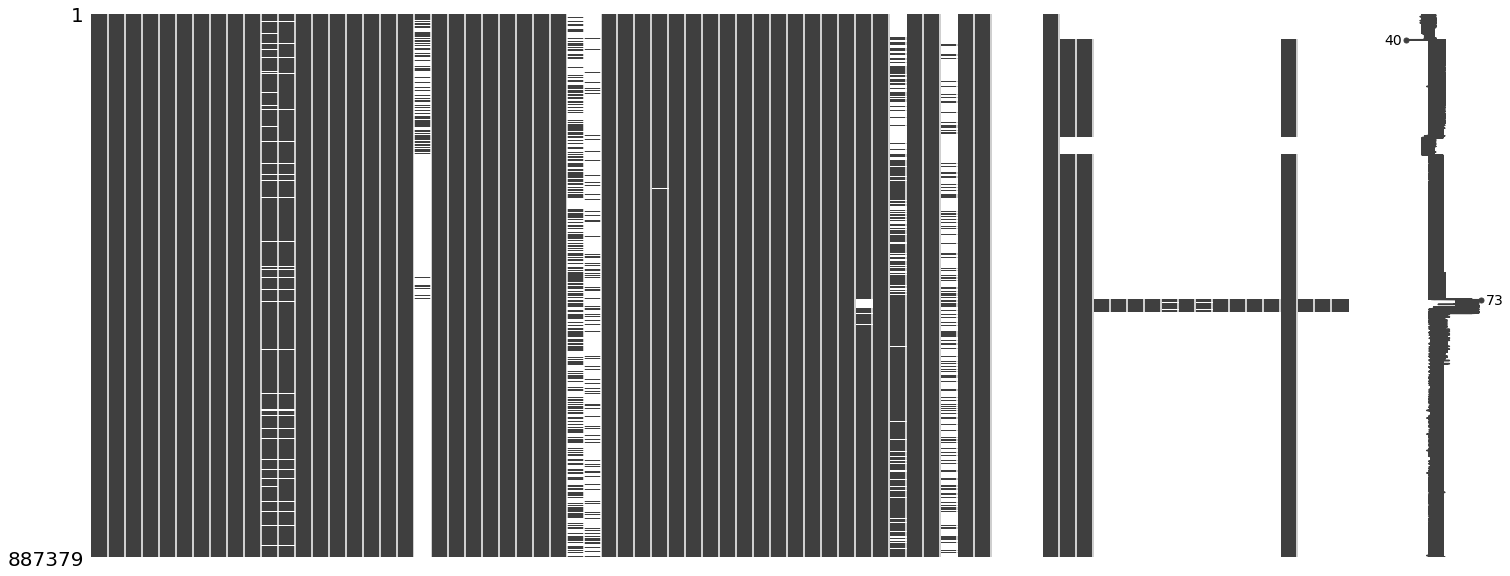

In [3]:
%matplotlib inline
msno.matrix(df)  
#The msno.matrix nullity matrix is a data-dense display which lets you quickly visually pick out patterns in data completion.
#visualize the missing data

In [4]:
df.shape   #dimension of our dataset

(887379, 74)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
id                             887379 non-null int64
member_id                      887379 non-null int64
loan_amnt                      887379 non-null float64
funded_amnt                    887379 non-null float64
funded_amnt_inv                887379 non-null float64
term                           887379 non-null object
int_rate                       887379 non-null float64
installment                    887379 non-null float64
grade                          887379 non-null object
sub_grade                      887379 non-null object
emp_title                      835917 non-null object
emp_length                     842554 non-null object
home_ownership                 887379 non-null object
annual_inc                     887375 non-null float64
verification_status            887379 non-null object
issue_d                        887379 non-null object
loan_status          

In [6]:
df.loan_status.value_counts()   #what we want to predict

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [7]:
#Part 1, pre-processing

In [8]:
#1-1, 
#Since the data can be devided into 2 groups, with co-borrowers or without co-borrowers
#application_type， Indicates whether the loan is an individual application or a joint application with two co-borrowers
df.application_type.value_counts()   
#only 511 has co-borrowers, so we drop all co-borrowers' information, and keep application_type(which can be a indicator for loan status)

INDIVIDUAL    886868
JOINT            511
Name: application_type, dtype: int64

In [9]:
new_df = df.drop(['annual_inc_joint','dti_joint','verification_status_joint','acc_now_delinq','tot_coll_amt','tot_cur_bal','open_acc_6m','open_il_6m','open_il_12m',
                  'open_il_24m','mths_since_rcnt_il','total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc','all_util',
                  'total_rev_hi_lim','inq_fi','total_cu_tl','inq_last_12m'], axis=1)
new_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,0.00,0.00,Jan-2015,357.48,NaN,Jan-2015,0.0,NaN,1.0,INDIVIDUAL
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,0.00,0.00,Jan-2016,67.79,Feb-2016,Jan-2016,0.0,NaN,1.0,INDIVIDUAL


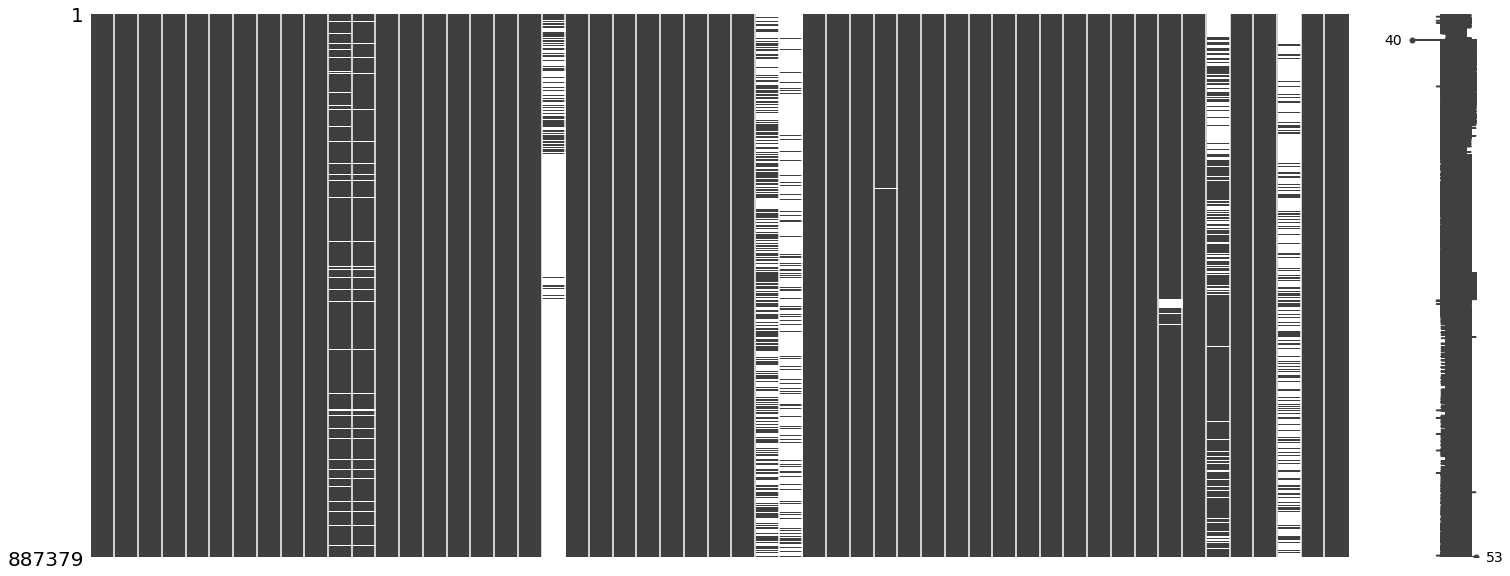

In [10]:
%matplotlib inline
msno.matrix(new_df)  

In [11]:
#1-2. Check Missing Value
missing_portion = new_df.isnull().sum()/len(new_df)    #calculate the portion of missing value
print(missing_portion.sort_values(ascending=False))
#Here,pick a value and drop the factors base on the missing portion
#My initial thought was drop everything above the "emp_title" , but when I looked into the columns' description
#Factors like mths_since_last_record is definitely related to loan status, so I have to look into these factors 1 by 1

desc                           0.857977
mths_since_last_record         0.845553
mths_since_last_major_derog    0.750160
mths_since_last_delinq         0.511971
next_pymnt_d                   0.285077
emp_title                      0.057993
emp_length                     0.050514
last_pymnt_d                   0.019900
revol_util                     0.000566
title                          0.000171
collections_12_mths_ex_med     0.000163
last_credit_pull_d             0.000060
total_acc                      0.000033
delinq_2yrs                    0.000033
inq_last_6mths                 0.000033
open_acc                       0.000033
pub_rec                        0.000033
earliest_cr_line               0.000033
annual_inc                     0.000005
url                            0.000000
member_id                      0.000000
loan_amnt                      0.000000
sub_grade                      0.000000
grade                          0.000000
installment                    0.000000


In [12]:
#a. desc: Loan description provided by the borrower
#can be dropped, texture data, and lots of missing value
new_df_2 = new_df.drop(['desc'], axis=1)

In [13]:
#b. mths_since_last_record: The number of months since the last public record.
#c. mths_since_last_major_derog: Months since most recent 90-day or worse rating
#d. mths_since_last_delinq: The number of months since the borrower's last delinquency.    
#can not be dropped, I guess the missing values should be replaced with "0" ***need further verification***
values = {'mths_since_last_record': 0, 'mths_since_last_major_derog': 0, 'mths_since_last_delinq': 0}

In [14]:
new_df_3 = new_df_2.fillna(value=values)

In [15]:
#e. next_pymnt_d: Next scheduled payment date
new_df_4 = new_df_3.drop(['next_pymnt_d'], axis=1)

In [16]:
new_df_4.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,0.00,0.00,0.00,Jan-2015,171.62,Jan-2016,0.0,0.0,1.0,INDIVIDUAL
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,0.00,117.08,1.11,Apr-2013,119.66,Sep-2013,0.0,0.0,1.0,INDIVIDUAL
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,0.00,0.00,0.00,Jun-2014,649.91,Jan-2016,0.0,0.0,1.0,INDIVIDUAL
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,16.97,0.00,0.00,Jan-2015,357.48,Jan-2015,0.0,0.0,1.0,INDIVIDUAL
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,0.00,0.00,0.00,Jan-2016,67.79,Jan-2016,0.0,0.0,1.0,INDIVIDUAL


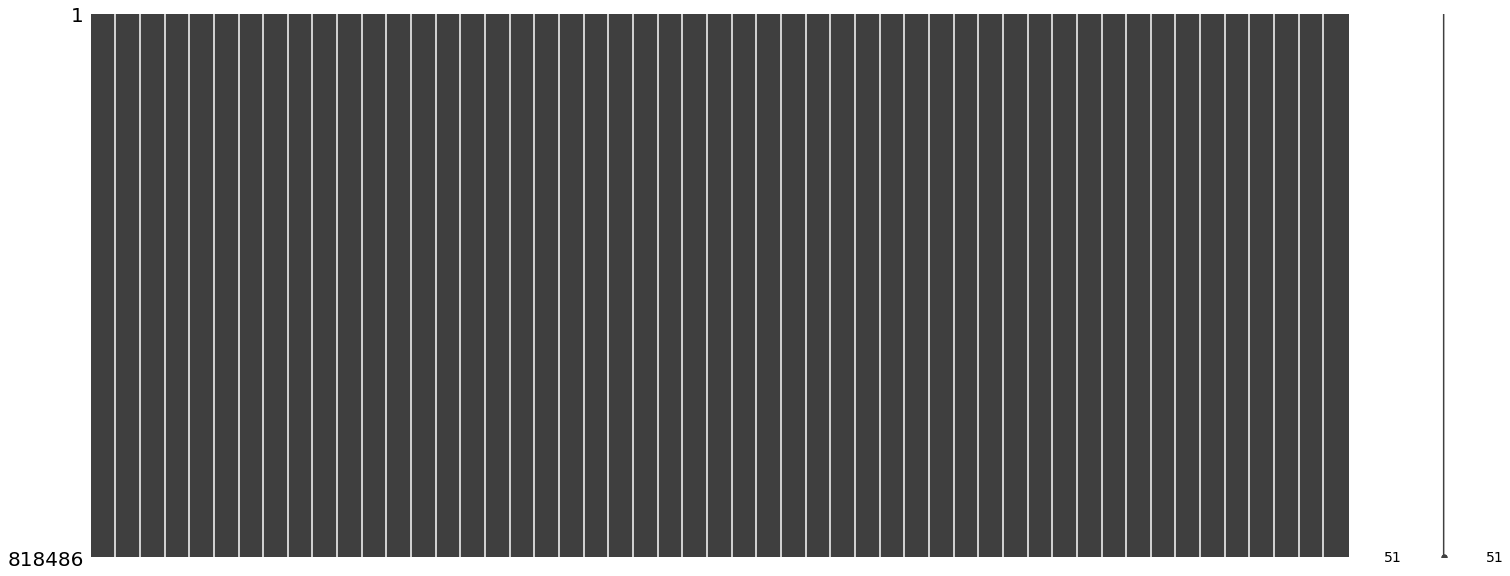

In [17]:
#1-3. Missing Value Continued.(replacing missing value)
df_no_missing = new_df_4.dropna()    #
%matplotlib inline
msno.matrix(df_no_missing)   #looks perfect, no missing value

In [18]:
#2-1. drop texture data, and unnecessary data
#id: A unique LC assigned ID for the loan listing.
#member_id: A unique LC assigned Id for the borrower member.
#emp_title: The job title supplied by the Borrower when applying for the loan.*
#url: URL for the LC page with listing data.
#policy_code: "publicly available policy_code=1, new products not publicly available policy_code=2"
df_no_missing_1 = df_no_missing.drop(['id','member_id','emp_title','url','policy_code'], axis=1)

In [19]:
#3-1. Status
df_status = df_no_missing_1
status_replace = {"loan_status" : { 'Current':0,'Issued':0,'Fully Paid':0,'In Grace Period':1,
                                   'Does not meet the credit policy. Status:Fully Paid':0,
                                   'Does not meet the credit policy. Status:Charged Off':1,
                                   'Default':1,
                                   'Late (31-120 days)':1,'Late (16-30 days)':1,'Charged Off':1 }}
                  #The Current is a great portion of the data, maybe we can do like this. "Good debt" vs "Bad debt"
df_status =df_status.replace(status_replace)
df_status.loan_status.value_counts() 

0    756830
1     61656
Name: loan_status, dtype: int64

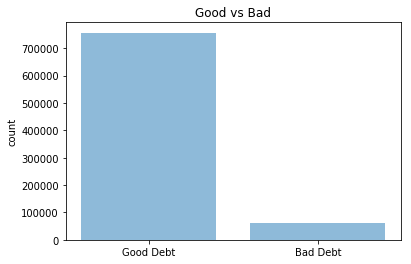

In [20]:
objects = ('Good Debt','Bad Debt')  #change names for title, ylab!
y_pos = np.arange(len(objects))
performance = df_status.loan_status.value_counts() 
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('count')
plt.title('Good vs Bad')
 
plt.show()

In [21]:
#3-2. Term
term_replace = {"term" : { ' 36 months':0,' 60 months':1 }}
df_term =df_status.replace(term_replace)
df_term.term.value_counts() 

0    567450
1    251036
Name: term, dtype: int64

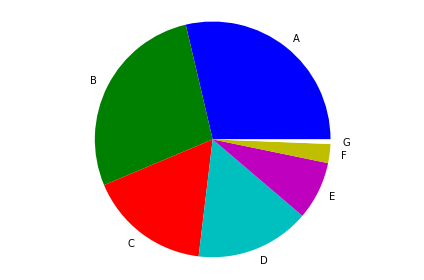

In [22]:
#3-3. Grade & Sub_grade
grade_replace = {"grade" : {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6 }}
df_grade =df_term.replace(grade_replace)
df_grade.grade.value_counts() 

sub_grade_replace = {"sub_grade" :{'A1':0, 'A2':1, 'A3':2, 'A4':3, 'A5':4,
                                   'B1':5, 'B2':6, 'B3':7, 'B4':8, 'B5':9,
                                   'C1':10,'C2':11,'C3':12,'C4':13,'C5':14,
                                   'D1':15,'D2':16,'D3':17,'D4':18,'D5':19,
                                   'E1':20,'E2':21,'E3':22,'E4':23,'E5':24,
                                   'F1':25,'F2':26,'F3':27,'F4':28,'F5':29,
                                   'G1':30,'G2':31,'G3':32,'G4':33,'G5':34
                                  }}
df_sub_grade =df_grade.replace(sub_grade_replace)
labels = 'A','B','C','D','E','F','G'
sizes = df_sub_grade.grade.value_counts()
colors = ['b','g','r','c','m','y','w']
plt.pie(sizes,colors=colors,labels=labels)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [23]:
#3-3. emp_length
emp_length_replace = { "emp_length": {"10+ years": 10,"9 years": 9,"8 years": 8,
                                      "7 years": 7, "6 years": 6, "5 years": 5,
                                      "4 years": 4, "3 years": 3, "2 years": 2,
                                      "1 year": 1, "< 1 year": 0,}}
df_emp_length =df_sub_grade.replace(emp_length_replace)
df_emp_length.emp_length.value_counts() 

10    282871
2      76917
0      68184
3      68018
1      55626
5      54031
4      51019
7      43520
8      42717
6      41816
9      33767
Name: emp_length, dtype: int64

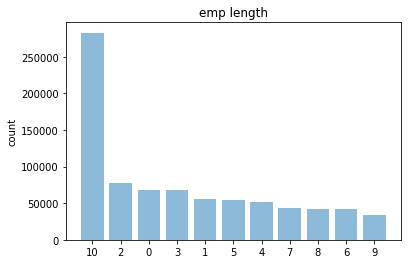

In [24]:
objects = '10','2','0','3','1','5','4','7','8','6','9' #change names for title, ylab!
y_pos = np.arange(len(objects))
performance = df_emp_length.emp_length.value_counts() 
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('count')
plt.title('emp length')
 
plt.show()
#insight: emp length longer, loan tends to be approved 

In [25]:
#3-4. home ownership
home_ownership_replace = { "home_ownership": {'MORTGAGE':0,'RENT':1,'OWN':3,'OTHER':4,'NONE':4,'ANY':4}}
df_home_ownership =df_emp_length.replace(home_ownership_replace)
df_home_ownership.home_ownership.value_counts() 

0    410936
1    331122
3     76211
4       217
Name: home_ownership, dtype: int64

In [34]:
#3-4. verification_status
verification_status_replace = { "verification_status": {'Not Verified':0,'Source Verified':1,'Verified':1}}
df_verification_status =df_home_ownership.replace(verification_status_replace)
df_verification_status.verification_status.value_counts() 

1    563343
0    255143
Name: verification_status, dtype: int64

In [35]:
#3-5. issue_d
df_issue_d = df_verification_status.drop(['issue_d'], axis=1)  #drop the issue_d

In [37]:
#3-6. pymnt_plan
df_pymnt_plan = df_issue_d.drop(['pymnt_plan'], axis=1)  #drop the pymnt_plan

In [44]:
#3-7. purpose 
le = preprocessing.LabelEncoder()
le.fit(df_pymnt_plan['purpose'])
df_pymnt_plan['purpose']=le.transform(df_pymnt_plan['purpose'])

In [128]:
#3-8.title
df_title = df_pymnt_plan.drop(['title'], axis=1)

In [129]:
#3-8.zip code
df_zip_code = df_title.drop(['zip_code'], axis=1)

In [133]:
#3-9. addr_state 
le = preprocessing.LabelEncoder()
le.fit(df_zip_code['addr_state'])
df_zip_code['addr_state']=le.transform(df_zip_code['addr_state'])

In [134]:
#3-10. earliest_cr_line
df_zip_code['earliest_cr_line']=df_zip_code['earliest_cr_line'].str.extract(r'(\d+)')
df_zip_code.earliest_cr_line.value_counts()
df_zip_code.loc[df_zip_code.earliest_cr_line.astype('int') < 1977, 'earliest_cr_line'] = 'earlier than 1977' 
le = preprocessing.LabelEncoder()
le.fit(df_zip_code['earliest_cr_line'])
df_zip_code['earliest_cr_line']=le.transform(df_zip_code['earliest_cr_line'])

In [137]:
#3-10. initial_list_status
le = preprocessing.LabelEncoder()
le.fit(df_zip_code['initial_list_status'])
df_zip_code['initial_list_status']=le.transform(df_zip_code['initial_list_status'])

In [139]:
#3-11. last_pymnt_d                  
df_last_pymnt_d = df_zip_code.drop(['last_pymnt_d'], axis=1)

In [140]:
#3-12. last_credit_pull_d                            
df_last_credit_pull_d = df_last_pymnt_d.drop(['last_credit_pull_d'], axis=1)

In [179]:
#3-13. application_type
le = preprocessing.LabelEncoder()
le.fit(df_last_credit_pull_d['application_type'])
df_last_credit_pull_d['application_type']=le.transform(df_last_credit_pull_d['application_type'])

In [180]:
df_last_credit_pull_d.columns   #remaining columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'loan_status', 'purpose',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'application_type'],
      dtype='object')

In [183]:
df_last_credit_pull_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 818486 entries, 1 to 887378
Data columns (total 40 columns):
loan_amnt                      818486 non-null float64
funded_amnt                    818486 non-null float64
funded_amnt_inv                818486 non-null float64
term                           818486 non-null int64
int_rate                       818486 non-null float64
installment                    818486 non-null float64
grade                          818486 non-null int64
sub_grade                      818486 non-null int64
emp_length                     818486 non-null int64
home_ownership                 818486 non-null int64
annual_inc                     818486 non-null float64
verification_status            818486 non-null int64
loan_status                    818486 non-null int64
purpose                        818486 non-null int64
addr_state                     818486 non-null int64
dti                            818486 non-null float64
delinq_2yrs                

In [193]:
corr = np.corrcoef(df_last_credit_pull_d, rowvar=0)
w, v = np.linalg.eig(corr)
w

array([6.95479859e+00, 4.08172098e+00, 3.52134369e+00, 2.05064958e+00,
       2.03258252e+00, 1.73690594e+00, 1.42713056e+00, 1.28599837e+00,
       1.23115722e+00, 1.09130820e+00, 1.04548463e+00, 1.02353612e+00,
       1.00035647e+00, 9.83172920e-01, 9.64139746e-01, 9.34249340e-01,
       9.35381634e-01, 8.73989124e-01, 8.44779336e-01, 7.92400442e-01,
       7.35827757e-01, 7.32173963e-01, 6.32033592e-01, 5.72061310e-01,
       5.22211448e-01, 4.93003280e-01, 4.52696748e-01, 3.34226199e-01,
       2.64536953e-01, 1.88026834e-01, 1.41993973e-01, 4.79737653e-02,
       3.95779991e-02, 1.39522246e-02, 1.21798224e-02, 5.38651346e-03,
       8.70616447e-04, 1.79020811e-04, 2.57312444e-06, 8.76999560e-15])

In [194]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [195]:
calculate_vif_(df_last_credit_pull_d,5.0)

dropping 'total_pymnt' at index: 29
dropping 'out_prncp_inv' at index: 28
dropping 'funded_amnt' at index: 1
dropping 'funded_amnt_inv' at index: 1
dropping 'total_pymnt_inv' at index: 26
dropping 'loan_amnt' at index: 0
dropping 'sub_grade' at index: 4
dropping 'int_rate' at index: 1
dropping 'installment' at index: 1
dropping 'open_acc' at index: 15
dropping 'total_rec_prncp' at index: 21
dropping 'earliest_cr_line' at index: 11
dropping 'dti' at index: 9
dropping 'revol_util' at index: 15
dropping 'total_acc' at index: 15
Remaining variables:
Index(['term', 'grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'loan_status', 'purpose', 'addr_state',
       'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'pub_rec', 'revol_bal', 'initial_list_status',
       'out_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt',
       'collections_12_mths_ex_med',

,term,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,delinq_2yrs,...,initial_list_status,out_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,application_type
1,1,2,0,1,30000.00,1,1,0,10,0.0,...,0,0.00,435.17,0.00,117.08,1.1100,119.66,0.0,0.0,0
3,0,2,10,1,49200.00,1,0,9,4,0.0,...,0,0.00,2209.33,16.97,0.00,0.0000,357.48,0.0,0.0,0
4,1,1,1,1,80000.00,1,0,9,37,0.0,...,0,766.90,1009.07,0.00,0.00,0.0000,67.79,0.0,0.0,0
5,0,0,3,1,36000.00,1,0,13,3,0.0,...,0,0.00,631.38,0.00,0.00,0.0000,161.03,0.0,0.0,0
6,1,2,8,1,47004.00,0,0,2,27,0.0,...,0,1889.15,3025.99,0.00,0.00,0.0000,170.08,0.0,0.0,0
7,0,4,9,1,48000.00,1,0,0,4,0.0,...,0,0.00,938.14,0.00,0.00,0.0000,111.34,0.0,0.0,0
9,1,1,0,1,15000.00,1,1,9,43,0.0,...,0,0.00,533.42,0.00,269.29,2.5200,121.45,0.0,0.0,0
10,1,2,5,3,72000.00,0,0,2,3,0.0,...,0,0.00,1177.52,0.00,0.00,0.0000,1655.54,0.0,0.0,0
11,0,1,10,3,75000.00,1,0,2,4,0.0,...,0,0.00,1943.08,0.00,0.00,0.0000,6315.30,0.0,0.0,0
12,0,2,0,1,30000.00,1,1,2,45,0.0,...,0,0.00,570.26,0.00,444.30,4.1600,305.38,0.0,0.0,0
